In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


import seaborn as sns
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd


initialisation

In [2]:
meal_data_path = 'meal_data.xlsx'
meal_data = pd.read_excel(meal_data_path)
meal_data.head()

,item_name,course_type,subcategories,meal_type,cost,nf_calories,nf_calories_from_fat,nf_total_fat,nf_saturated_fat,nf_trans_fatty_acid,...,nf_vitamin_a_dv,nf_vitamin_c_dv,nf_calcium_dv,nf_iron_dv,nf_potassium,nf_servings_per_container,nf_serving_size_qty,nf_serving_size_unit,nf_serving_weight_grams,images_front_full_url
0,Trick OR Treat Ice Cream,Soup,cream,NaN,2.08,300.00,140.0,16.0,9.0,0.0,...,8.0,2.0,15.0,4.0,NaN,NaN,4.00,oz scoops,NaN,NaN
1,Sweet Fries Snack,Side,fried,NaN,2.27,1150.00,690.0,79.0,7.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,13.40,oz,NaN,NaN
2,Tomatoes - Salad,Side,red orange,NaN,3.45,9.58,2.4,0.0,0.0,0.0,...,5.0,14.0,0.0,0.0,NaN,NaN,45.52,Grams,45.52,NaN
3,Chicken BBQ Caesar Salad EntrÌ©e,Main dish,poultry,NaN,3.95,203.00,NaN,NaN,2.1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2.00,servings,NaN,NaN
4,Corn and Black Bean Salad,Side,legume,NaN,3.59,140.00,10.0,1.0,0.0,0.0,...,2.0,4.0,2.0,10.0,NaN,NaN,1.00,Salad,NaN,NaN


In [35]:
score_preference_path = 'customer_dish_preferences.xlsx'
score_preference = pd.read_excel(score_preference_path)
score_preference.set_index('Unnamed: 0', inplace=True)
score_preference.head()
score_preference.shape

(28, 210)

In [4]:
nutrition_criteria_path = 'nutrition_criteria.xlsx'
nutrition_criteria = pd.read_excel(nutrition_criteria_path)
nutrition_criteria.head()


,ID,Element,F,M,Average
0,1,Calories,1600,2000,1800
1,2,Sodium,2300,2300,2300
2,3,Carbohydrate,130,130,130
3,4,Dietary_fiber,22,28,25
4,5,Protein,46,56,51


In [ ]:
num_item = 210
# calculate pi
X = score_preference.copy()
features = list(X.columns)
X = X.values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=5) 
X_pca = pca.fit_transform(X_scaled)

kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_pca) 
score_preference['cluster'] = clusters

def p_score(score_preference, p_number):
    score_mean = pd.DataFrame()

    total_samples = len(score_preference)
    p_weight = []
    for cluster_label in range(p_number):
        cluster_size = len(score_preference[score_preference['cluster'] == cluster_label])
        p_weight.append(cluster_size / total_samples)

    for i, p_weight in enumerate(p_weight):
        print(f"p {i+1}: {p_weight:.2f}")

    for cluster_label in range(p_number):
        cluster_data = score_preference[score_preference['cluster'] == cluster_label] 
        cluster_mean = cluster_data.drop('cluster', axis=1).mean() 
        score_mean[cluster_label] = cluster_mean 

    score_mean = score_mean.T
    print("\nAverage values for each p:")
    print(score_mean)

    return p_weight, score_mean

p_score(score_preference, p_number=3)
p_weight, score_mean = p_score(score_preference, p_number=3)
patron_cluster = dict(enumerate(clusters))

item_names = [meal_data.loc[i, "item_name"] for i in range(num_item)]

pi = { p: { i: 0 for i in range(num_item) } for p in range(3) }
for p in range(3):
    for i in range(num_item):
        dish_name = item_names[i]
        try:
            pi[p][i] = score_mean.loc[p, dish_name]
        except KeyError:
            print(f'not found: {dish_name}')
            pi[p][i] = 0

# check pi
for p in range(3):
    print(f'cluster {p} preference score:', pi[p])
pi

p 1: 0.25
p 2: 0.43
p 3: 0.32

Average values for each p:
   Trick OR Treat Ice Cream  Sweet Fries Snack  Tomatoes - Salad  \
0                  2.000000           1.285714          1.428571   
1                  1.833333           1.916667          1.833333   
2                  2.333333           2.111111          2.333333   

   Chicken BBQ Caesar Salad EntrÌ©e  Corn and Black Bean Salad  Mango Cake  \
0                          1.285714                   2.000000    1.857143   
1                          2.083333                   2.083333    1.916667   
2                          2.666667                   2.222222    2.333333   

        Egg  Flavored Fresh Lemonade, Peach  Add Pirate Tossed Salad  \
0  1.428571                        1.571429                 2.142857   
1  2.083333                        1.583333                 1.666667   
2  2.444444                        2.666667                 2.333333   

   Blueberry Vinaigrette  ...  Vegetable Stir-Fry  Vegetable Lasagn

{0: {0: 2.0,
  1: 1.2857142857142858,
  2: 1.4285714285714286,
  3: 1.2857142857142858,
  4: 2.0,
  5: 1.8571428571428572,
  6: 1.4285714285714286,
  7: 1.5714285714285714,
  8: 2.142857142857143,
  9: 2.142857142857143,
  10: 1.4285714285714286,
  11: 1.5714285714285714,
  12: 2.0,
  13: 2.0,
  14: 2.0,
  15: 2.142857142857143,
  16: 2.142857142857143,
  17: 2.4285714285714284,
  18: 1.5714285714285714,
  19: 1.4285714285714286,
  20: 2.0,
  21: 1.8571428571428572,
  22: 1.7142857142857142,
  23: 2.142857142857143,
  24: 1.8571428571428572,
  25: 1.7142857142857142,
  26: 1.7142857142857142,
  27: 1.5714285714285714,
  28: 2.2857142857142856,
  29: 1.7142857142857142,
  30: 1.4285714285714286,
  31: 2.142857142857143,
  32: 1.7142857142857142,
  33: 2.0,
  34: 1.5714285714285714,
  35: 1.2857142857142858,
  36: 1.7142857142857142,
  37: 1.1428571428571428,
  38: 1.5714285714285714,
  39: 1.8571428571428572,
  40: 1.4285714285714286,
  41: 1.7142857142857142,
  42: 2.4285714285714284,


In [ ]:
# Data preprocessing: score normalization
scores_normalized = score_mean.div(score_mean.sum(axis=1), axis=0)*1000
anaylsis_scores = scores_normalized.T
# change column names
anaylsis_scores.columns = ['P1', 'P2', 'P3']

anaylsis_scores

,P1,P2,P3
Trick OR Treat Ice Cream,5.196733,4.440856,4.848765
Sweet Fries Snack,3.340757,4.642713,4.386978
Tomatoes - Salad,3.711952,4.440856,4.848765
Chicken BBQ Caesar Salad EntrÌ©e,3.340757,5.046427,5.541445
Corn and Black Bean Salad,5.196733,5.046427,4.617871
...,...,...,...
Vegetable Chili,4.454343,4.844570,5.310552
Stuffed Bell Peppers,5.196733,4.238999,5.079658
Vegetable Moussaka,5.939124,4.440856,5.310552
Vegetable Biryani,5.196733,5.046427,4.848765


In [7]:
print(meal_data.index)

RangeIndex(start=0, stop=210, step=1)


In [8]:
anaylsis_scores = anaylsis_scores.reset_index(drop=True)
print(anaylsis_scores.index)


RangeIndex(start=0, stop=210, step=1)


In [9]:
anaylsis_combined = pd.concat([meal_data, anaylsis_scores], axis=1)
anaylsis_combined

,item_name,course_type,subcategories,meal_type,cost,nf_calories,nf_calories_from_fat,nf_total_fat,nf_saturated_fat,nf_trans_fatty_acid,...,nf_iron_dv,nf_potassium,nf_servings_per_container,nf_serving_size_qty,nf_serving_size_unit,nf_serving_weight_grams,images_front_full_url,P1,P2,P3
0,Trick OR Treat Ice Cream,Soup,cream,NaN,2.08,300.00,140.0,16.0,9.0,0.0,...,4.0,NaN,NaN,4.00,oz scoops,NaN,NaN,5.196733,4.440856,4.848765
1,Sweet Fries Snack,Side,fried,NaN,2.27,1150.00,690.0,79.0,7.0,0.0,...,NaN,NaN,NaN,13.40,oz,NaN,NaN,3.340757,4.642713,4.386978
2,Tomatoes - Salad,Side,red orange,NaN,3.45,9.58,2.4,0.0,0.0,0.0,...,0.0,NaN,NaN,45.52,Grams,45.52,NaN,3.711952,4.440856,4.848765
3,Chicken BBQ Caesar Salad EntrÌ©e,Main dish,poultry,NaN,3.95,203.00,NaN,NaN,2.1,NaN,...,NaN,NaN,NaN,2.00,servings,NaN,NaN,3.340757,5.046427,5.541445
4,Corn and Black Bean Salad,Side,legume,NaN,3.59,140.00,10.0,1.0,0.0,0.0,...,10.0,NaN,NaN,1.00,Salad,NaN,NaN,5.196733,5.046427,4.617871
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,Vegetable Chili,Main dish,vegetable,NaN,3.50,460.00,NaN,13.0,2.0,NaN,...,7.0,1169.1,NaN,NaN,NaN,NaN,NaN,4.454343,4.844570,5.310552
206,Stuffed Bell Peppers,Main dish,vegetable,NaN,4.00,444.00,NaN,24.0,9.6,NaN,...,4.0,937.0,NaN,NaN,NaN,NaN,NaN,5.196733,4.238999,5.079658
207,Vegetable Moussaka,Main dish,vegetable,NaN,4.50,295.00,NaN,17.0,9.1,NaN,...,1.5,422.4,NaN,NaN,NaN,NaN,NaN,5.939124,4.440856,5.310552
208,Vegetable Biryani,Main dish,vegetable,NaN,4.80,198.00,NaN,3.9,0.6,NaN,...,1.0,256.8,NaN,NaN,NaN,NaN,NaN,5.196733,5.046427,4.848765


In [10]:
course_type_analysis = anaylsis_combined[['course_type', 'P1', 'P2', 'P3']]
course_type_analysis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   course_type  210 non-null    object 
 1   P1           210 non-null    float64
 2   P2           210 non-null    float64
 3   P3           210 non-null    float64
dtypes: float64(3), object(1)
memory usage: 6.7+ KB


In [11]:
course_avg = course_type_analysis.groupby("course_type").mean()
course_avg


,P1,P2,P3
course_type,,,
Appetizer,4.289367,4.822141,4.412632
Breakfast,5.020904,4.589593,4.763699
Dessert,4.852052,4.628295,4.815780
Main dish,4.753983,4.720537,4.809819
Salad,4.677060,4.723456,4.756407
Side,4.825538,4.865098,4.735275
Soup,4.542723,4.863795,4.760805


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# initialize MinMaxScaler, set the target range to [1, 3].
scaler = MinMaxScaler(feature_range=(1, 3))

# normalize each column.
course_avg_normalized = pd.DataFrame(
    scaler.fit_transform(course_avg),
    columns=course_avg.columns,
    index=course_avg.index
)

print(course_avg_normalized)

                   P1        P2        P3
course_type                              
Appetizer    1.000000  2.688163  1.000000
Breakfast    3.000000  1.000000  2.741627
Dessert      2.538364  1.280952  3.000000
Main dish    2.270244  1.950579  2.970427
Salad        2.059941  1.971765  2.705455
Side         2.465875  3.000000  2.600616
Soup         1.692666  2.990538  2.727273


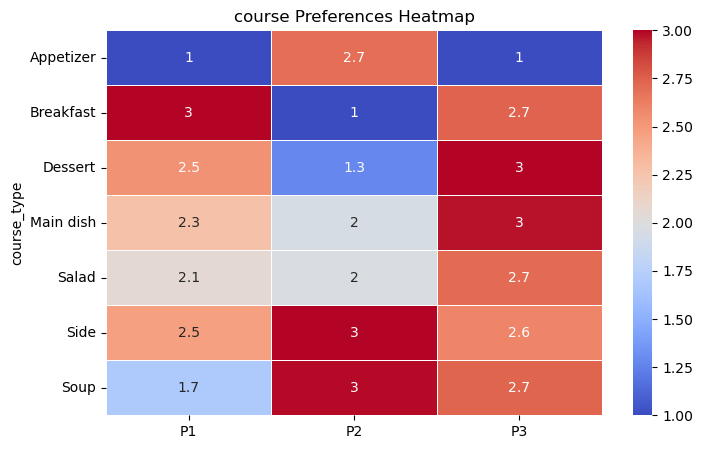

In [31]:
plt.figure(figsize=(8, 5))
sns.heatmap(course_avg_normalized, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("course Preferences Heatmap")
plt.show()


In [13]:
subcategories_analysis = anaylsis_combined[['subcategories', 'P1', 'P2', 'P3']]
subcategories_avg = subcategories_analysis.groupby("subcategories").mean()
subcategories_avg


,P1,P2,P3
subcategories,,,
Pork,5.196733,4.037142,4.502424
batter,4.887404,4.508142,4.694836
beef,4.918337,4.731025,4.819903
cake,4.825538,4.575427,4.887247
clear,4.825538,5.046427,4.156084
cream,4.825538,4.592249,4.993073
dark green,4.268745,4.743642,4.935350
egg,5.419451,4.319742,4.617871
fish,4.613427,4.613876,5.178613


In [ ]:
# initialize MinMaxScaler, set the target range to [1, 3].
scaler = MinMaxScaler(feature_range=(1, 3))

# normalize each column.
course_avg_normalized = pd.DataFrame(
    scaler.fit_transform(subcategories_avg),
    columns=subcategories_avg.columns,
    index=subcategories_avg.index
)

print(course_avg_normalized)

                       P1        P2        P3
subcategories                                
Pork             2.500000  1.000000  1.666667
batter           2.083333  1.833333  2.037037
beef             2.125000  2.227679  2.277778
cake             2.000000  1.952381  2.407407
clear            2.000000  2.785714  1.000000
cream            2.000000  1.982143  2.611111
dark green       1.250000  2.250000  2.500000
egg              2.800000  1.500000  1.888889
fish             1.714286  2.020408  2.968254
fried            1.357143  2.326531  2.142857
fruit            2.312500  2.696429  2.000000
grain            2.038462  2.291209  1.888889
ice cream        1.375000  1.982143  1.888889
legume           1.875000  2.785714  1.888889
meat             2.200000  2.142857  2.600000
noodle           1.000000  2.785714  2.000000
pasta            2.055556  2.349206  1.296296
pie              3.000000  2.428571  3.000000
pork             2.300000  3.000000  2.866667
pottage          1.375000  2.60714

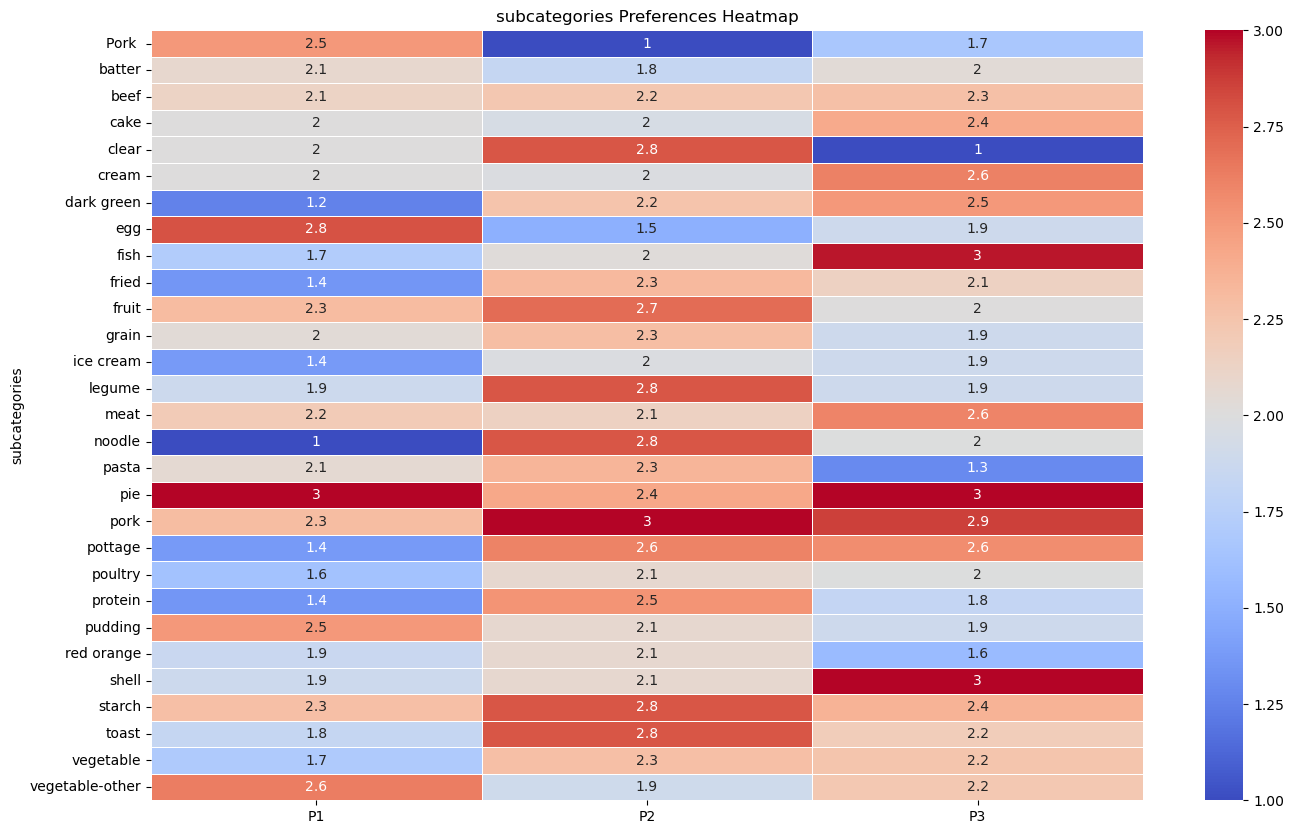

In [33]:
plt.figure(figsize=(16, 10))
sns.heatmap(course_avg_normalized, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("subcategories Preferences Heatmap")
plt.show()

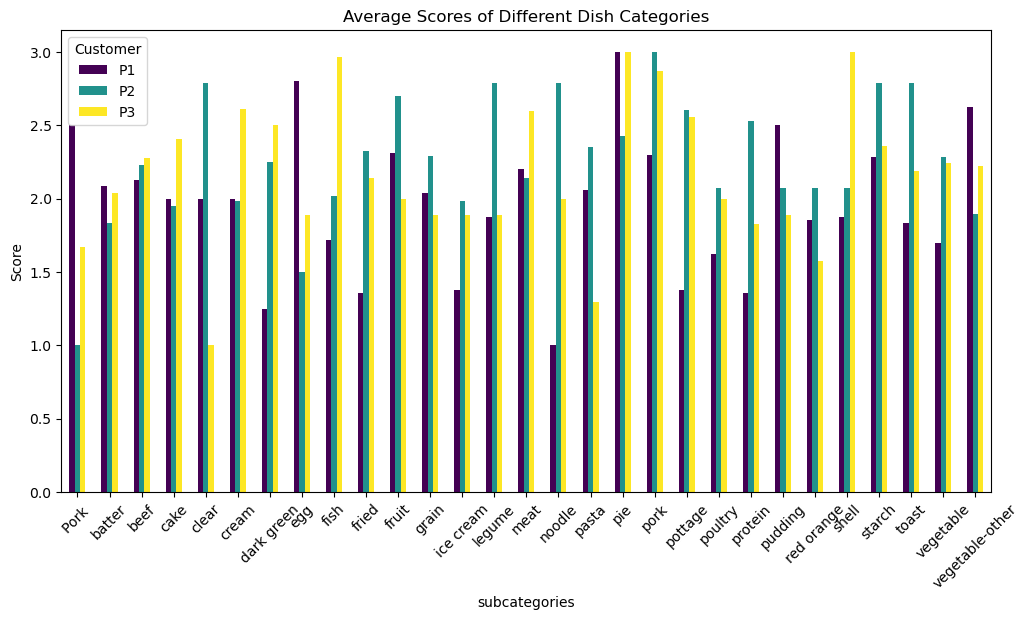

In [ ]:
course_avg_normalized.plot(kind='bar', figsize=(12, 6), colormap='viridis')
plt.title("Average Scores of Different Dish Categories")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(title="Customer")
plt.show()